In [1]:
# I'm going rogue and starting with one of the flights I'm interested in....
# Based on Will's tutorial notebook

## Here is a list of objectives for this tutorial. Try to find (cmd-f) these numbers in the commented sections:
    # 1)  - Import our class functions and verify installation
    # 2)  - Load Drone Data
    # 3)  - Load Correlator Data
    # 4)  - Initialize a concat class for a PULSED GRID FLIGHT
    # 5)  - Perform a series of analysis functions on the concat class...
    # 5A) - concat Function: Extract_Source_Pulses
    # 5B) - concat Function: Perform_Background_Subtraction
    # 5C) - concat Function: Synchronization_Function
    # 5D) - concat Function: Export_yaml
    # 5E) - concat Function: Main_Beam_Fitting

In [2]:
## First import general packages for running python analysis:
import os
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import h5py
import datetime
import pytz

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

In [8]:
# Useful analysis stuff I will need to somehow code:
#Epols = [0,3,4,7,9,10,12,14]
#Npols = [1,2,5,6,8,11,13,15]

Epols = [0,2,4,6,8,10,12,14]
Npols = [1,3,5,7,9,11,13,15]

# dishes are 2n, 2n+1 pairs

In [4]:
###################
#### FUNCTIONS ####
###################

In [7]:
def plot_something(drone_class,coo='lat',t_bounds=[0,-1]):
    print('plotting drone coordinates for all time samples:')
    fig1,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(15,9))
    ## Plot p0 coordinate origin:
    ax1.plot(drone_class.origin[0],drone_class.origin[1],'ro')
    ax2.axhline(drone_class.origin[0],c='b')
    ax3.axhline(drone_class.origin[1],c='b')
    ## Title each coordinate subplot:        
    ax1.set_title('Lat vs Lon')
    ax2.set_title('Lat vs Time')
    ax3.set_title('Lon vs Time')
    ax4.set_title('Velocity vs Time')
    ax5.set_title('Altitude vs Time')
    ax6.set_title('Yaw vs Time')
    ## Specify arrays/vectors to plot in 1,3,4 coordinate subplot
    if coo=='lat':
        xqtys=[drone_class.latitude,drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index]
        yqtys=[drone_class.longitude,drone_class.latitude,drone_class.longitude,drone_class.velocity,drone_class.altitude,drone_class.yaw]
        xtags=['Latitude, [$deg$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
        ytags=['Longitude, [$deg$]','Latitude, [$deg$]','Longitude, [$deg$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
        print('overplotting drone coordinates for t_cut samples: ['+str(t_bounds[0])+':'+str(t_bounds[1])+']')
        for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
            ax.plot(np.nanmin(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmin(yqtys[i][t_bounds[0]:t_bounds[1]]))
            ax.plot(np.nanmax(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmax(yqtys[i][t_bounds[0]:t_bounds[1]]))
            autoscalelims=ax.axis()
            ax.clear()
            ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
            ax.plot(xqtys[i][t_bounds[0]:t_bounds[1]],yqtys[i][t_bounds[0]:t_bounds[1]],'.',label='selected samples')
            ax.set_xlabel(xtags[i])
            ax.set_ylabel(ytags[i])
            ax.grid()
            ax.legend()
            ax.set_xlim(autoscalelims[0],autoscalelims[1])
            ax.set_ylim(autoscalelims[2],autoscalelims[3])
        tight_layout()
      
    if coo=='xy':
        xqtys=[drone_class.coords_xyz_LC[:,0],drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index]
        yqtys=[drone_class.coords_xyz_LC[:,1],drone_class.coords_xyz_LC[:,0],drone_class.coords_xyz_LC[:,1],drone_class.velocity,drone_class.altitude,drone_class.yaw]
        xtags=['X, [$m$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
        ytags=['Y, [$m$]','X [$m$]','Y [$m$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
        print('overplotting drone coordinates for t_cut samples: ['+str(t_bounds[0])+':'+str(t_bounds[1])+']')
        for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
            ax.plot(np.nanmin(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmin(yqtys[i][t_bounds[0]:t_bounds[1]]))
            ax.plot(np.nanmax(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmax(yqtys[i][t_bounds[0]:t_bounds[1]]))
            autoscalelims=ax.axis()
            ax.clear()
            ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
            ax.plot(xqtys[i][t_bounds[0]:t_bounds[1]],yqtys[i][t_bounds[0]:t_bounds[1]],'.',label='selected samples')
            ax.set_xlabel(xtags[i])
            ax.set_ylabel(ytags[i])
            ax.grid()
            ax.legend()
            ax.set_xlim(autoscalelims[0],autoscalelims[1])
            ax.set_ylim(autoscalelims[2],autoscalelims[3])
        tight_layout()
        

## 1. Fitting time offsets, background, writing yamls and Gaussian values

In [3]:
# Checking if the flight and numbers correspond from what I've written in the spreadsheet
#fly = '533'
#cdat= '20210826T182904Z'

fly = '534'
cdat = '20210826T185621Z'

#fly = '535'
#cdat = '20210826T192056Z'

#fly = '536'
#cdat = '20210826T195003Z'

#fly='613'
#cdat='20211021T144905Z'

#fly = '615'
#cdat = '20211021T151650Z'

#fly = '618'
#cdat = '20211021T183430Z'

#process='yes'

if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    aindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

print('start time: ', datetime.datetime.now())

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)


corrtest0825=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])
print('end time: ', datetime.datetime.now())

start time:  2023-03-07 12:08:14.310129
20210826T185632Z /hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/ /hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T185621Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY534.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 12316/12316 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/
  --> Arrays initialized with shape (97, 256, 1024, 8)
Assigning array values by reading in data files:
  --> Loading File: 0096/0096
  --> Finished. Reshaping arrays.
end time:  2023-03-07 12:11:04.090406


plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


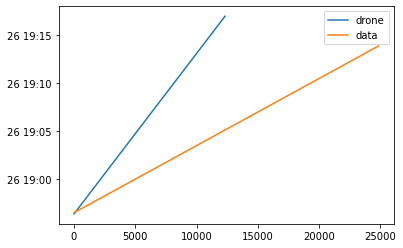

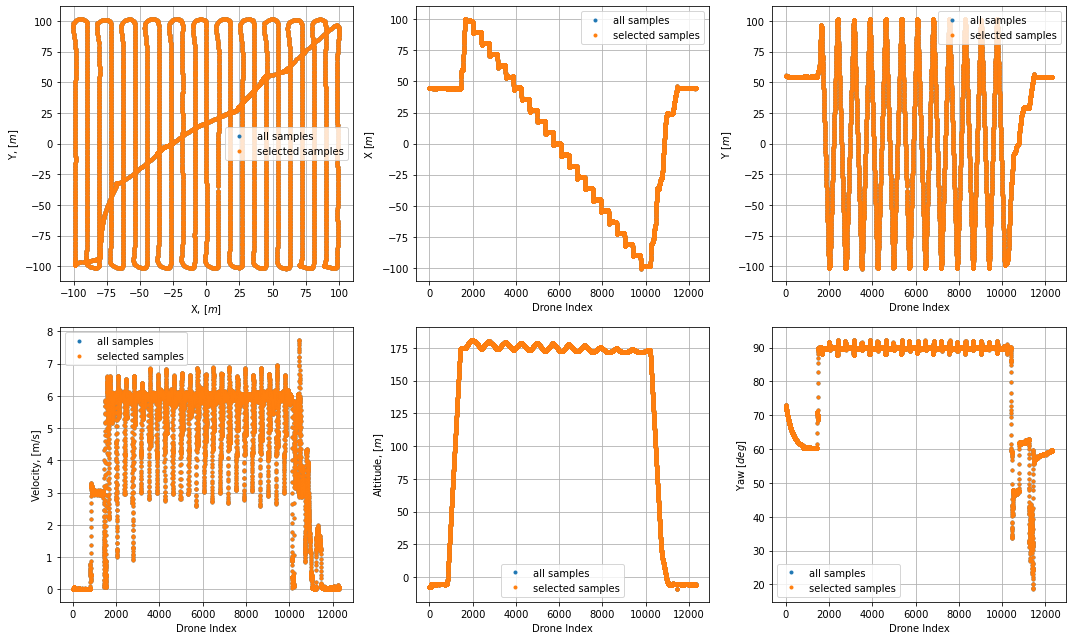

In [9]:
# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()

plot_something(dronetest0825,'xy',t_bounds=[0,-1])

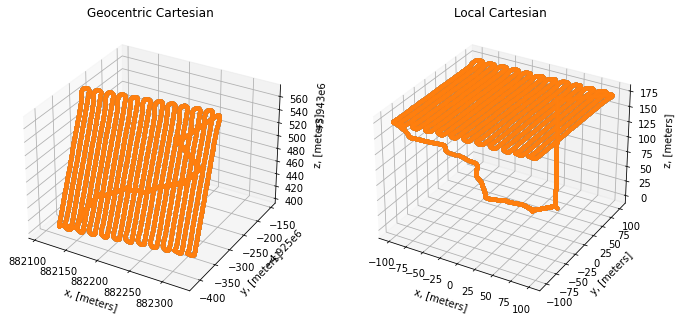

In [6]:
pu.Plot_3d(dronetest0825)

In [12]:
# Match drone and correlator data together, and plot a few frequencies

config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             #load_yaml=True,traceback=True,save_traceback=False)
concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,load_yaml=True,traceback=True,save_traceback=False)

pu.Plot_Time_Series(concattest0825,freqlist=[200,400,700,900]) # previously set to just 700

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T195003Z_yale_drone/corr/20210826T195014Z/
  --> FLY536.csv
  --> Traceback outputs will not be saved...


TypeError: expected str, bytes or os.PathLike object, not _io.TextIOWrapper

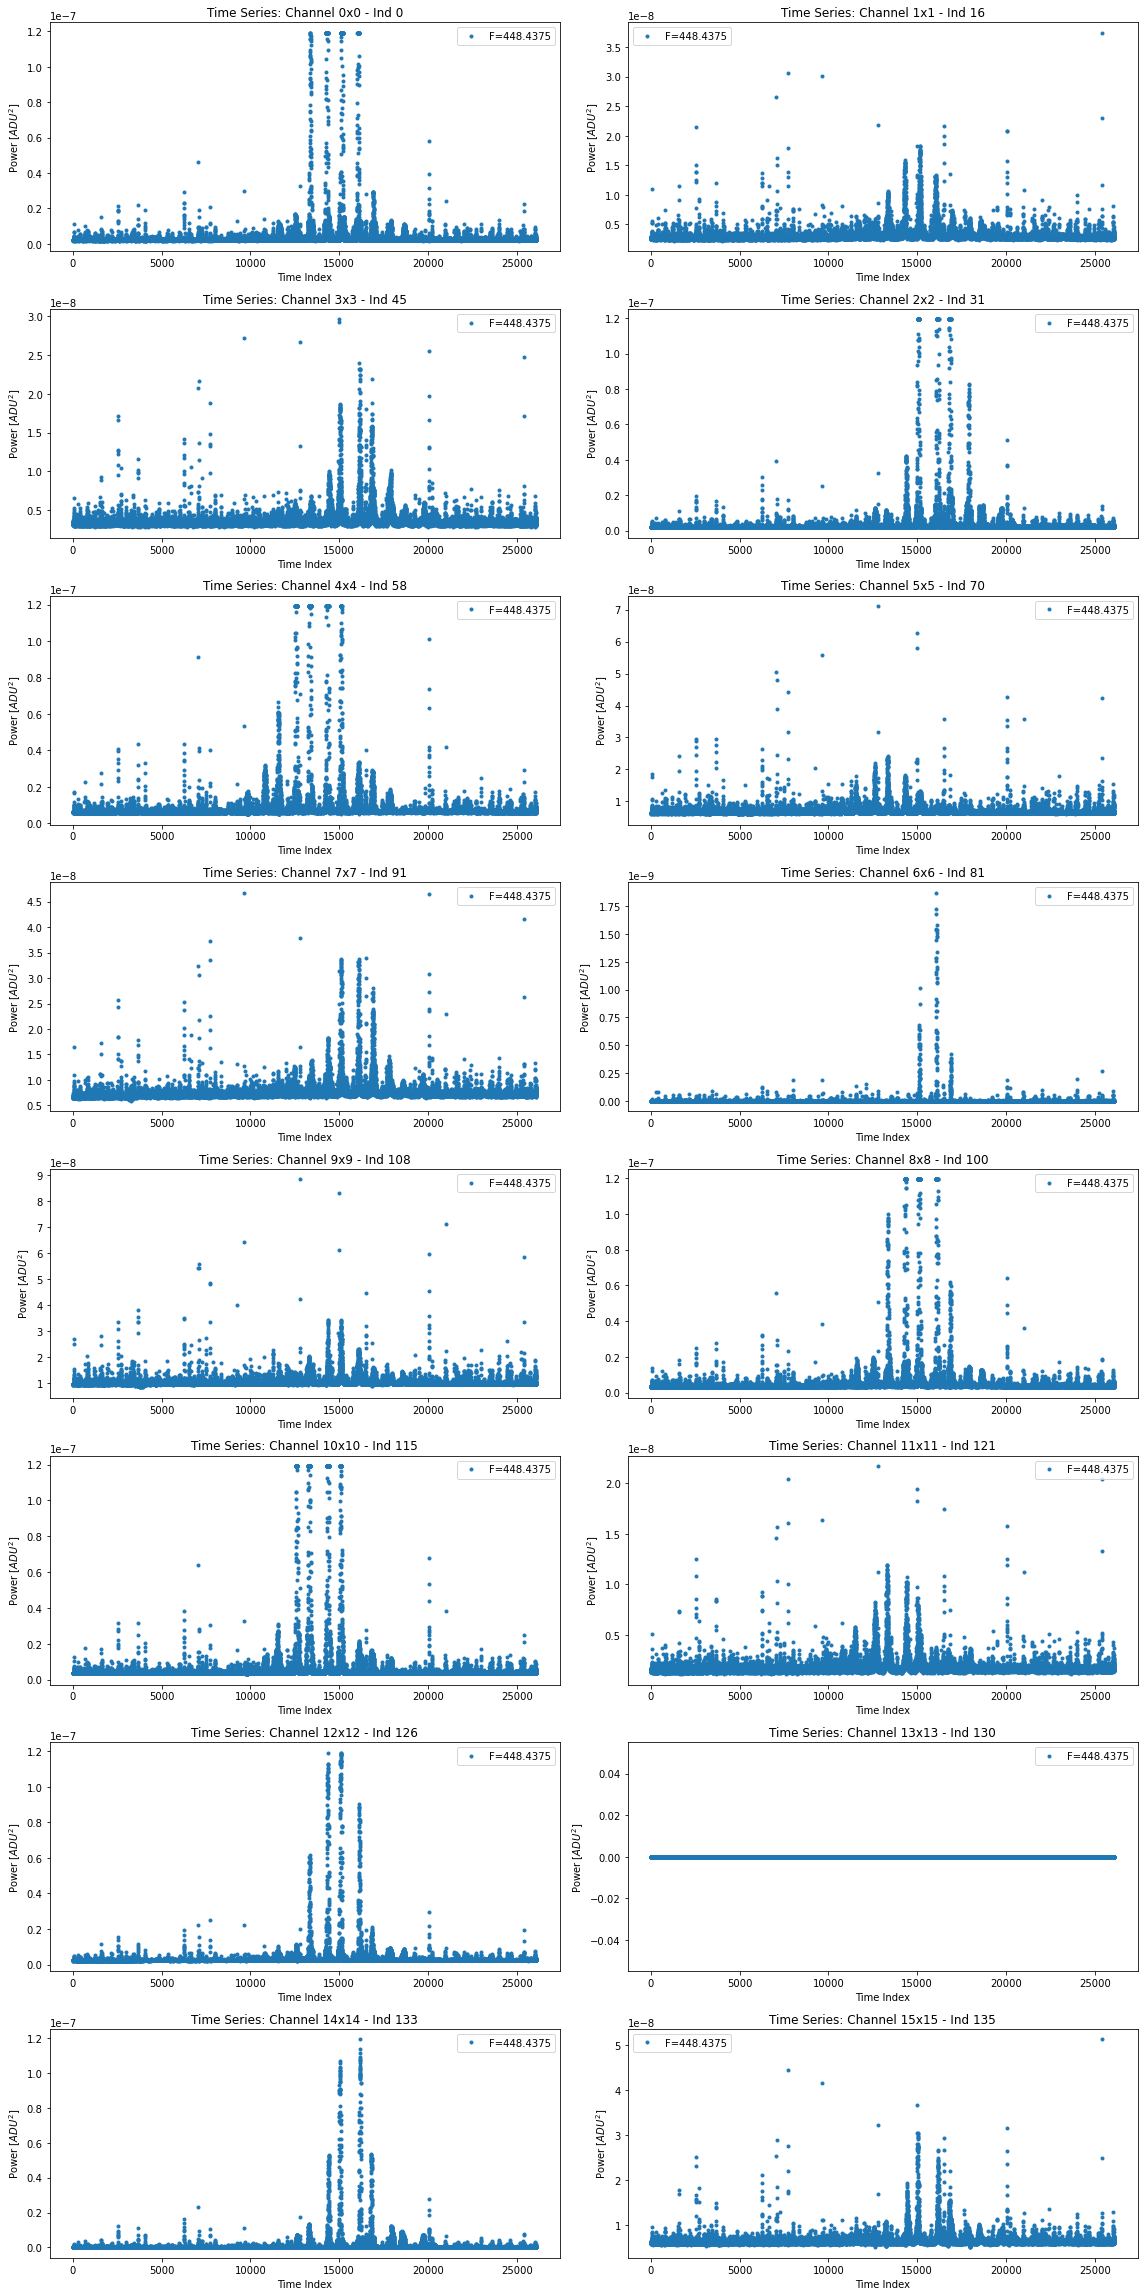

In [9]:
pu.Plot_Time_Series(concattest0825,freqlist=[900])

In [ ]:
## Let's find the time bounds for a central transit, and examine those bounds when we solve for the source pulses:
tlb,tub=[15000,22000]
find=900

fig=figure(figsize=(16,8))
for i in range(concattest0825.n_channels)[:2]:
    ax1=fig.add_subplot(2,2,i+1)
    ax2=fig.add_subplot(2,2,i+3)
    ax1.semilogy(concattest0825.t_index[:],concattest0825.V[:,find,concattest0825.chmap[i]],'.')
    for ax in [ax1,ax2]:
        ax.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb:tub,find,concattest0825.chmap[i]],'.')
ax1.set_xlim(tlb,tub)
ax2.set_xlim(tlb,tub)

## So we've identified time bounds where we can see the pulsing source transit!
    ## Infact, I think we are seeing a sidelobe on channel 1!
    ## Let's see if we can extract the on/off indices...

In [ ]:
## OBJECTIVE 5A: concat Function: Extract_Source_Pulses

## Let's use the Extract_Source_Pulses function:
    # The Period and Dutycycle options are known beforehand, and given in microseconds.
    # The t_bounds option just determines the plot bounds, not the solving routine.
## Fortunately, these parameters are loaded from the config, so we don't have to wait for the solver to run.
    ## The returned t_delta_pulse parameter will be given in seconds.
    ## In the verification plot, we should see the following points plotted:
        # orange_o = inds_off  = times when the source is off
        # blue_o   = inds_on   = times when the source is on and broadcasting
        # green_x  = inds_span = times where the behavior changes during the integration period (omit always!)
    ## The print statements shows the list of indices that appear in more than one of on/off/span.
        ## If they are all empty lists [], then there is no overlap which is a good thing.
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[tlb,tub])

In [ ]:
## OBJECTIVE 5B: concat Function: Perform_Background_Subtraction

## Let's do background subtraction: creates computed background (V_bg) and background-subtracted (V_bgsub) arrays:
    # window_size=5 - this is 1/2 the width of the 'index window' across which the background is averaged.
    # This function only works if the source was pulsed and Extract_Source_Pulses was used!
concattest0825.Perform_Background_Subtraction(window_size=5)

In [ ]:
## OBJECTIVE 5C: concat Function: Synchronization_Function

## This function finds the absolute timing shift between the dji data from the drone and the correlator
    ## We will be loading t_delta_dji from the config file to save some time!
    ## This function only works if the source was pulsed and if V_bgsub was created using background subtraction.
    ## This function works by zooming into the gaussian main beam and removing saturated data points...
## To run, you must give the following:
    ## inputcorr  = the corr class used in the concat
    ## inputdrone = the drone class used in the concat
## The optional parameters and their default values are listed below:
    ## coarse_params=[-10.0,10.0,0.2]    = the min,max,step parameters for the coarse time offset array
    ## fine_params=[-0.5,0.5,0.01]       = the min,max,step parameters for the fine time offset array
    ## chans=np.arange(0,2)              = the channels to fit. 0,1 gives us each polarization
    ## freqs=np.arange(100,1024,150)     = the min,max,step parameters for the freq array axis
    ## FMB_coordbounds=[50.0,50.0,150.0] = the cartesian coords we restrict around the main beam
        # x within +/- 50m from dish center in Local Cartesian (LC)
        # y within +/- 50m from dish center in Local Cartesian (LC)
        # z > 150m from dish center in Local Cartesian (LC)
    ## FMB_ampbound=0.999                = amplitude percentile threshold for saturation... 
        # time indices where the amplitude exceeds 0.999*maximum value are excluded because they are saturated

concattest0825.Synchronization_Function(inputcorr=corrtest0825,inputdrone=dronetest0825,FMB_coordbounds=[50.0,50.0,150.0],FMB_ampbound=0.999)

## Since we are loading from the config, we get to skip an iterative loop and just take the solution and apply it.
    ## The verification plot shown is hidden when traceback==False is set in the concat initialization
    ## Look closely at the verification plots to see which channel appears to be the co-pol (channel 1)
    ## In the bottom 2 panels, compare the fit result (white gaussian) to the data points (in color)
        ## We are omitting the saturated points to find the REAL max value, instead of squashing our peak
        ## If we are satisfied with this fit, we should try to save the parameters we found...

In [ ]:
## OBJECTIVE 5D: concat Function: Export_yaml

## When we have results we want to save, we should export our results to a config file for future use:
    ## The file will be written to the directory stated when the concat class was initialized.
    ## If a concat config yaml file already exists, a new version will be saved.
## Uncomment this if you want to export a config file... 
concattest0825.Export_yaml()

In [ ]:
## OBJECTIVE 5E: concat Function: Main_Beam_Fitting

## Now we can do some analysis, since we have synchronized useful data. We can begin by fitting the main beam:
    ## You can specify the directory where you want the fit params to be output:
    ## fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    ## This one sometimes takes a while, feel free to get a coffee or something.
concattest0825.Main_Beam_Fitting(fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/')

In [ ]:
print(len(concattest0825.G_popt[:,0,0]),len(concattest0825.G_popt[0,:,0]),len(concattest0825.G_popt[0,0,:]))
N = len(concattest0825.G_popt[0,:,0])


plt.plot(freqs,concattest0825.G_popt[0,:,0],'b.')
plt.ylabel('Amplitude')
plt.xlabel('Freq [MHz]')
plt.show()

plt.plot(freqs,concattest0825.G_popt[0,:,2],'b.')
plt.ylabel('Xsig [m]')
plt.xlabel('Freq [MHz]')
plt.show()

plt.plot(freqs,concattest0825.G_popt[0,:,4],'b.')
plt.ylabel('Ysig [m]')
plt.xlabel('Freq [MHz]')
plt.show()

plt.plot(freqs,np.abs(concattest0825.G_popt[0,:,5]),'b.')
plt.ylabel('Theta [rad]')
plt.xlabel('Freq [MHz]')
plt.ylim(-np.pi/4,np.pi/4)
plt.show()